<a href="https://colab.research.google.com/github/rdemarqui/llm_complaint_management/blob/main/03.%20Backlog_NTT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tagging Customer Feedback with LLM

This study aims to explore the advanced LLM tool Mistral 7B to analyze a vast collection of complaints gathered from the website [reclameaqui.com.br](reclameaqui.com.br). Through this analysis, we intend to demonstrate the potential and effectiveness of LLMs in interpreting and handling large-scale user feedback.

For more information, please visit github page: https://github.com/rdemarqui/llm_complaint_management

## Complaint Dataset

### Load

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sns.set_theme()

In [ ]:
# Loading data
data_url = 'https://raw.githubusercontent.com/rdemarqui/llm_complaint_management/main/datasets/full_dataset_claro.xlsx'
data = pd.read_excel(data_url, usecols=['problem', 'description'])
print(data.shape)

(7000, 2)


### Clean

In [ ]:
# Remove extra space and uncase all words
data['description'] = data['description'].astype(str)
data['description'] = data['description'].str.replace(r'\s{2,}', ' ', regex=True)
data['description'] = data['description'].str.lower()

In [ ]:
# Modify mask made by reclame aqui
def remove_mask(text):
  return text.replace("[editado pelo reclame aqui]", "[mask]")

data['description'] = data['description'].apply(remove_mask)

In [ ]:
# Remove description less than 3 characters
data = data[data['description'].str.len() > 3].copy()

### Stratify

As this work is intended for study purposes, we will only work with a fraction of the data. With the infrastructure provided by the Colab free tier, we noticed that on average, Mistral 7B analyzes about 2.000 complaints per hour (zero shot). Therefore, we will use this number of cases in our analysis. To do this, we will perform a stratified sample.

We also will use validation data with 202 examples to test some prompt engineering.

In [ ]:
# Get stratified data
df, data_val = train_test_split(data, train_size=2002, stratify=data['problem'], random_state=42)
df_val, _  = train_test_split(data_val, train_size=202, stratify=data_val['problem'], random_state=42)
df.reset_index(inplace=True, drop=True)
df_val.reset_index(inplace=True, drop=True)
print(f"Validation data: {df_val.shape} \nTest data: {df.shape}")

Validation data: (202, 2) 
Test data: (2002, 2)


In [ ]:
# Export dataset to tag mannualy
df_val.to_excel('df_validation.xlsx', index=False)

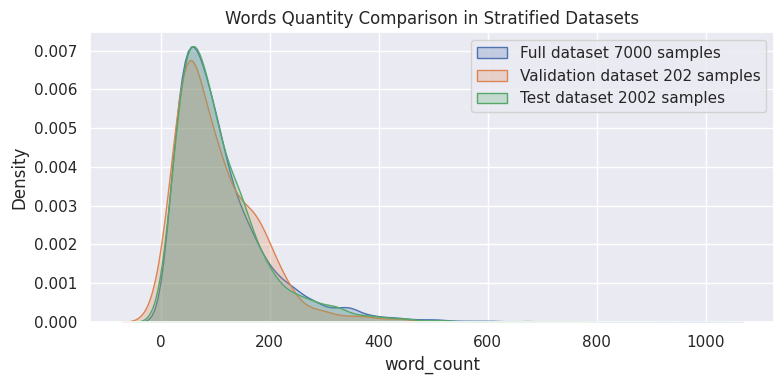

In [ ]:
# Comparing word distributions
data['word_count'] = data['description'].str.split().str.len()
df['word_count'] = df['description'].str.split().str.len()
df_val['word_count'] = df_val['description'].str.split().str.len()

fig, ax = plt.subplots(figsize=(8, 4))
sns.kdeplot(data=data['word_count'], label='Full dataset 7000 samples', fill=True, ax=ax)
sns.kdeplot(data=df_val['word_count'], label='Validation dataset 202 samples', fill=True, ax=ax)
sns.kdeplot(data=df['word_count'], label='Test dataset 2002 samples', fill=True, ax=ax)
ax.legend()
plt.title('Words Quantity Comparison in Stratified Datasets')
plt.tight_layout()
plt.show()

### Analysis

In [ ]:
df.head()

,problem,description,word_count
0,Problemas com o chip,boa noite!!!fiz uma portabilidade da vivo para...,203
1,Problemas com o chip,perdi meu celular e ao tentar solicitar um nov...,66
2,Corte indevido da linha,é a segunda reclamação que estou fazendo e a c...,32
3,Cancelamento,solicitei portabilidade da vivo para a claro p...,136
4,Problemas com o chip,"contratei este prezao celular, paguei 20,00 re...",13


In [ ]:
# Show each problem category
df['problem'].value_counts()

Problemas com o chip                       143
Corte indevido da linha                    143
Cancelamento                               143
Problema com recarga                       143
Planos e tarifas                           143
Mudança de plano                           143
Promoções                                  143
Qualidade da internet                      143
Consumo de crédito                         143
Instabilidade do sinal                     143
Demora na execução                         143
Cobrança indevida                          143
Portabilidade                              143
Mau atendimento do prestador de serviço    143
Name: problem, dtype: int64

In [ ]:
# Show words statistics
df['word_count'] = df['description'].str.split().str.len()
df['text_len'] = df['description'].str.len()
df['word_count'].describe()

count    2002.000000
mean      110.619381
std        86.131142
min         2.000000
25%        53.000000
50%        87.000000
75%       143.000000
max       747.000000
Name: word_count, dtype: float64

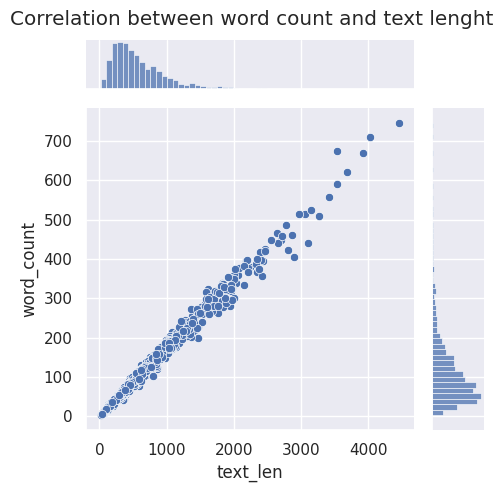

In [ ]:
# Check correlation between word count and text lenght
chart_joint = sns.jointplot(data=df, x="text_len", y="word_count", height=5)
chart_joint.fig.suptitle("Correlation between word count and text lenght")
chart_joint.fig.tight_layout()
chart_joint.fig.subplots_adjust(top=0.92)

In [ ]:
# Check word median per category
df.groupby('problem')['word_count'].median()

problem
Cancelamento                                95.0
Cobrança indevida                          113.0
Consumo de crédito                          83.0
Corte indevido da linha                    106.0
Demora na execução                          82.0
Instabilidade do sinal                      67.0
Mau atendimento do prestador de serviço     92.0
Mudança de plano                           100.0
Planos e tarifas                            98.0
Portabilidade                               99.0
Problema com recarga                        73.0
Problemas com o chip                        90.0
Promoções                                   63.0
Qualidade da internet                       74.0
Name: word_count, dtype: float64

## Text Classification

### Load Model

There are several 7B models available as open source, such as Mistral, Falcon, Zephyr, and Openchat. In this study we will use Mistral, but other models can also be tested, just paying attention to adapting the instruction structure.

In [2]:
import time
from datetime import timedelta, datetime
from google.colab import files
from IPython.display import clear_output

In [3]:
# Latest HF transformers version for Mistral-like models
!pip install git+https://github.com/huggingface/transformers.git

# GPTQ Dependencies
!pip install optimum
!pip3 install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/  # Use cu117 if on CUDA 11.7

clear_output()

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

We will load the pre-trained Mistral 7B model, quantized by the user TheBloke and available at https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GPTQ.

For more information on quantization, there is an excellent article written by Maxime Labonne:
* https://towardsdatascience.com/introduction-to-weight-quantization-2494701b9c0c

In [5]:
# Load LLM and Tokenizer
model_id = "TheBloke/Mistral-7B-Instruct-v0.2-GPTQ"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    trust_remote_code=False,
    revision="main"
)
clear_output()

In [6]:
# Create a pipeline
generator = pipeline(model=model,
                tokenizer=tokenizer,
                task='text-generation',
                max_new_tokens=60,
                temperature=0.1,
                do_sample=True,
                return_full_text = False
                )
clear_output()

### Prompt Engineering

In [7]:
def llm_analysis(prompt, complain):
  response = generator(prompt.format(user_complain=complain))
  llm_classification = response[0]['generated_text'].replace('.', '').lower()

  return llm_classification

In [8]:
def iterate_over_interval(df, column, prompt, limit_char, start_row, end_row, save):
  start_time = time.time()

  for nloop, index in enumerate(range(start_row, end_row)):
    complaint_content = str(df.loc[index, column]).lower()

    # Checkpoint
    if (nloop + 1) % 100 == 0:
      delta_time = str(timedelta(seconds=time.time() - start_time)).split('.')[0]
      print(f"{delta_time} Analysis number {nloop + 1}")

    # Limit text lengh
    if len(complaint_content) > limit_char: complaint_content = complaint_content[:limit_char]+'\n'

    #print(prompt.format(user_complain=complaint_content))  # check prompt

    # Text analysis
    analysis = llm_analysis(prompt, complaint_content)
    df.at[index, 'llm_class'] = analysis

  # Save final result
  delta_time = str(timedelta(seconds=time.time() - start_time)).split('.')[0]
  print(f"{nloop + 1} cases analyzed. Total execution time: {delta_time}")

  if save == True:
    current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
    file_name = 'analise_reclamacao_' + str(start_row) + '_' + str(end_row) + current_datetime + '.xlsx'
    df.to_excel(file_name, index=False)

  return df, file_name if save == True else df

Prompt Guide:
* https://www.promptingguide.ai/models/mistral-7b
* https://huggingface.co/docs/transformers/main/tasks/prompting

In [9]:
# Define tags
#tags = ['sinal/conexão de rede', 'cobrança indevida', 'consumo saldo/crédito',
#        'plano/benefício', 'cancelamento linha/plano', 'chip/sim card', 'spam',
#        'portabilidade', 'recarga/pagamento', 'dificuldade de contato']

tags = ['sinal/conexão de rede', 'VAS', 'streaming', 'chip/sim card', 'portabilidade',
        'consumo saldo/crédito', 'recarga/pagamento']


# Transform tag list in one string
tags_string = ", ".join(f"{tag}" for tag in tags)

tags_string

'sinal/conexão de rede, VAS, streaming, chip/sim card, portabilidade, consumo saldo/crédito, recarga/pagamento'

In [10]:
# Create tamplates
complain_template = """
Reclamação: '{user_complain}'"""

task_template = """
Tarefa: Classifique a reclamação entre aspas. Atenção use apenas as categorias abaixo.
{tags}""".format(tags=tags_string)

warning = """
Importante, apenas classifique sem explicar!"""

In [11]:
# Prompt user complain
prompt_task_after = '[INST]' + complain_template + '\n' + task_template + '\n' + warning +'\n\nRótulos:[/INST]'
prompt_task_before = '[INST]' + task_template + '\n' + complain_template + '\n' + warning + '\n\nRótulos:[/INST]'

In [12]:
# Multi-turn conversation
dialog_dict = {
    "conv1_1t": ["Esse plano é ruim!", "plano/benefício"],
    "conv2_1t": ["Recebo muitas mensagens de propaganda", "spam"]
}

# Conversation 1 with 1 tags, task after
a_conv1_1t = prompt_task_after.format(user_complain=dialog_dict['conv1_1t'][0]) + " " + dialog_dict['conv1_1t'][1]

# Conversation 2 with 2 tags, task after
a_conv2_1t = prompt_task_after.format(user_complain=dialog_dict['conv2_1t'][0]) + " " + dialog_dict['conv2_1t'][1]

# Conversation 1 with 1 tags, task before
b_conv1_1t = prompt_task_before.format(user_complain=dialog_dict['conv1_1t'][0]) + " " + dialog_dict['conv1_1t'][1]

# Conversation 2 with 2 tags, task before
b_conv2_1t = prompt_task_before.format(user_complain=dialog_dict['conv2_1t'][0]) + " " + dialog_dict['conv2_1t'][1]

In [13]:
# Prompt: task after complain
p_tsk_aft_0s = prompt_task_after  # zero shot
p_tsk_aft_1s = '<s>' + a_conv1_1t + '\n</s>\n' + prompt_task_after  # one shot
p_tsk_aft_2s = '<s>' + a_conv1_1t + '\n</s>' + '\n<s>' + a_conv2_1t + '\n</s>\n' + prompt_task_after  # two shot

# Prompt: task before complain
p_tsk_bfr_0s = prompt_task_before  # zero shot
p_tsk_bfr_1s = '<s>' + b_conv1_1t + '\n</s>\n' + prompt_task_before  # one shot
p_tsk_bfr_2s = '<s>' + b_conv1_1t + '\n</s>' + '\n<s>' + b_conv2_1t + '\n</s>\n' + prompt_task_before  # two shot

prompt_dict = {'p_tsk_aft_0s': p_tsk_aft_0s, 'p_tsk_aft_1s': p_tsk_aft_1s, 'p_tsk_aft_2s': p_tsk_aft_2s,
               'p_tsk_bfr_0s': p_tsk_bfr_0s, 'p_tsk_bfr_1s': p_tsk_bfr_1s, 'p_tsk_bfr_2s': p_tsk_bfr_2s}

In [14]:
# Print each prompt (check)
for prompt in prompt_dict:
  print(30*'-')
  print('-', prompt)
  print(prompt_dict[prompt])

------------------------------
- p_tsk_aft_0s
[INST]
Reclamação: '{user_complain}'

Tarefa: Classifique a reclamação entre aspas. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, VAS, streaming, chip/sim card, portabilidade, consumo saldo/crédito, recarga/pagamento

Importante, apenas classifique sem explicar!

Rótulos:[/INST]
------------------------------
- p_tsk_aft_1s
<s>[INST]
Reclamação: 'Esse plano é ruim!'

Tarefa: Classifique a reclamação entre aspas. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, VAS, streaming, chip/sim card, portabilidade, consumo saldo/crédito, recarga/pagamento

Importante, apenas classifique sem explicar!

Rótulos:[/INST] plano/benefício
</s>
[INST]
Reclamação: '{user_complain}'

Tarefa: Classifique a reclamação entre aspas. Atenção use apenas as categorias abaixo.
sinal/conexão de rede, VAS, streaming, chip/sim card, portabilidade, consumo saldo/crédito, recarga/pagamento

Importante, apenas classifique sem explicar!

Rót

We gonna try several prompt examples, as described in the table below:

|Prompt name|Task|Shot|
|--|--|--|
|p_tsk_aft_0s|After complaint|zero|
|p_tsk_aft_1s|After complaint|one|
|p_tsk_aft_2s|After complaint|two|
|p_tsk_bfr_0s|Before complaint|zero|
|p_tsk_bfr_1s|Before complaint|one|
|p_tsk_bfr_2s|Before complaint|two|

In [40]:
choose = 'p_tsk_aft_0s'
prompt_dict2 = {choose: prompt_dict[choose]}
# Run the example few times to see model consistency
example ="""
Siebel não gera o protocolo de atendimento, apresentando o erro "não é possível criar um atendimento sem uma ligação ativa"
"""[:2000].replace('\n', ' ').lower()

print(example)

for prompt in prompt_dict2:
  print('\n - ', prompt)
  for i in list(range(1, 4)):
    analysis = llm_analysis(prompt_dict[prompt], example)
    print(analysis)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 siebel não gera o protocolo de atendimento, apresentando o erro "não é possível criar um atendimento sem uma ligação ativa" 

 -  p_tsk_aft_0s


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 sinal/conexão de rede


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 sinal/conexão de rede
 sinal/conexão de rede


In [25]:
example ="""Siebel não gera o protocolo de atendimento, apresentando o erro "não é possível criar um atendimento sem uma ligação ativa"
"""[:2000].replace('\n', ' ').lower()

prompt_test = """[INST]
Reclamação: {recl}

Classifique a reclamação.
Certifique-se de retornar apenas as palavras-chave e não dizer mais nada.

Classificação:[/INST]
""".format(recl=example)

#print(prompt_test)

llm_analysis(prompt_test, example)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'1 siebel\n2 atendimento\n3 protocolo\n4 erro\n5 ligação ativa\n6 não possível\n7 criar atendimento\n8 system issue'

In [47]:
example ="""
[PROTOCOLO:2024065641414 - T3592518 - Lorrayne Silva Pereira 01/25/2024 13:32:10 - BO Cons Help Solutions/Almaviva BH - (Aberto) - cliente reclama que nao esta conseguindo usa a internet cliente reclama que esta sem sinal desde de madrugada foi feito reset porem nao resolveu tirou o chip e nao resolveu por favor verificar]

[PROTOCOLO:2024065641414 - T3666636 - Fabiana Lopes De Sales 01/25/2024 08:57:43 - FE Pos Migração Oi/Almaviva - (Aberto) - [Descrição da falha do Cliente dificuldade de utilizar internet (x ) Não conecta ( ) Baixa velocidade ( ) Queda de Conexão ( ) WhatsApp Qual o número com problema? 63) 98424-2929 Telefone alternativo para contato? (63) 98451-0459 Qual o plano/Oferta contratado pelo Cliente? TIM MAIS B Já foi realizado reset do aparelho/modem? ( ) Sim ( ) Não. Se sim, qual o resultado? O Cliente recebe alguma mensagem de falha? ( ) Sim ( ) Não. Se sim, qual a mensagem? A falha ocorre com outros Clientes TIM na mesma localidade? ( ) Sim ( ) Não A falha ocorre somente em local interno? ( ) Sim ( ) Não Já foi feito teste com o chip do Cliente em outro aparelho/modem? ( ) Sim ( ) Não. Se sim, qual o resultado? Para aparelhos Dual Chip - O Chip preferido para dados é o Chip da TIM? O Chip preferido para dados está no modo de conexão automática (2G, 3G, 4G e 5G)? Após troca, falha permanece? ( ) Sim ( ) Não Logradouro da falha (Rua/Avenida/Estrada): Nº: Bairro: Cidade: Estado: CEP: Ruas próximas, ruas transversais e ruas paralelas: É zona Rural? Se sim informar locais públicos para localização, Ex: Praças, escolas, rodovias e etc. O aparelho do Cliente está configurado para? ( )2G(GSM) ( )3G(UMTS) ( ) 4G (LTE) ( ) 5G ( ) Rede Automática Qual a condição de cobertura do endereço reclamado no site portas abertas? 2G ( ) TOTAL ( ) PARCIAL ( ) SEM COBERTURA 3G ( ) TOTAL ( ) PARCIAL ( ) SEM COBERTURA 4G ( ) TOTAL ( ) PARCIAL ( ) SEM COBERTURA 5G ( ) TOTAL ( ) PARCIAL ( ) SEM COBERTURA A falha ocorre somente esse endereço? ( ) Sim ( ) Não Se não, especifique outro endereço: Descrição da falha:mesmo apos troca do chip cliente não consegue utilizar internet | 25/1/2024 8:56:28 | T3666636 | Fabiana Lopes De Sales | FE Pos Migração Oi/Almaviva-1-Consultor | FE Pos Migração Oi/Almaviva ]]
"""[:2000].replace('\n', ' ').lower()

prompt_test = """
<s>[INST]
Tenho a seguinte reclamação:
- O sinal é muito ruim. O app não funciona

Classifique o problema.
Certifique-se de apenas classificar e não dizer mais nada.

Classificação:[/INST] conexão de rede, app</s>
[INST]
Tenho a seguinte reclamação:
- {recl}

Classifique o problema com as chaves a seguir:
plano/benefício, VAS, conexão de rede, app, streaming, roaming, portabilidade, chip/sim card, cobrança indevida, cancelamento linha/plano, recarga/pagamento, aprovisionamento
Certifique-se de apenas classificar e não dizer mais nada.

Classificação:[/INST]""".format(recl=example)

#print(prompt_test)

llm_analysis(prompt_test, example)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


' conexão de rede, chip/sim card'

**Note:** As we can be seen below, model tends to use more labels wen we pass multi-turn conversations with 2 exemple labels.

#### Multi-label Evaluation

In this section we will evaluate our prompt. To do that we labaled mannualy the **df_val** dataframe to use as comparision with model output.

There are a few metrics to evaluate multi-label classification, in this work we gonna use `classification_report`from `sklearn`, that is a well known package wich give us manny metrics to analyse. If you you want to know more about it, there's a good article made by Aniruddha Karajgi, on https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea.

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Creates binary classification columns and sum total classifications
def binary_cols(dataframe, column, tags):
  for tag in tags:
      dataframe[tag] = dataframe[column].apply(lambda x: 1 if tag in x else 0)

  dataframe[column + '_sum'] = dataframe[tags].sum(axis=1)

**Note:** Depending on the amount of data, the classification process can take a few hours. Using the quantized model described above, with zero shot prompt and utilizing the free tier infrastructure of Colab, I noticed that Mistral 7B takes about an hour to classify 2.000 cases.

Colab tends to disconnect due to inactivity. To prevent this, open your browser's inspector, go to the console tab, paste the code below, and press enter.

`function ClickConnect(){
    console.log("Working");
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)`

In [ ]:
# Open validation dataset tagged manually
df_val_url = 'https://raw.githubusercontent.com/rdemarqui/llm_complaint_management/main/datasets/df_validation.xlsx'
df_val_labeled = pd.read_excel(df_val_url)

In [ ]:
# Check each prompt performance
y_expected = df_val_labeled[tags]
score_dict = {}
file_name_dict = {}

for prompt in prompt_dict:
  print("\n- ", prompt)
  temp_df, file_name = iterate_over_interval(df=df_val, column="description", prompt=prompt_dict[prompt],
                                             limit_char=2000, start_row=0, end_row=df_val.shape[0], save=True)

  binary_cols(dataframe=temp_df, column='llm_class', tags=tags)

  y_pred = temp_df[tags]

  score_dict[prompt] = classification_report(y_expected, y_pred, output_dict=True, target_names=tags)
  file_name_dict[prompt] = file_name


-  p_tsk_aft_0s
0:01:58 Analysis number 100
0:03:48 Analysis number 200
202 cases analyzed. Total execution time: 0:03:52

-  p_tsk_aft_1s
0:03:03 Analysis number 100
0:06:04 Analysis number 200
202 cases analyzed. Total execution time: 0:06:10

-  p_tsk_aft_2s
0:04:50 Analysis number 100
0:09:37 Analysis number 200
202 cases analyzed. Total execution time: 0:09:47

-  p_tsk_bfr_0s
0:01:53 Analysis number 100
0:04:03 Analysis number 200
202 cases analyzed. Total execution time: 0:04:07

-  p_tsk_bfr_1s
0:03:15 Analysis number 100
0:06:26 Analysis number 200
202 cases analyzed. Total execution time: 0:06:32

-  p_tsk_bfr_2s
0:05:08 Analysis number 100
0:10:16 Analysis number 200
202 cases analyzed. Total execution time: 0:10:26


There's some ways to agregate metrics such as `micro average`, `macro avarage`, `weighted average` and `samples average`. In this study we gonna use `samples avg`, wich was specifically designed for multilabel scenarios. It calculates metrics like precision, recall, and F1-score for each instance individually and averages them, thus effectively evaluating the model's performance on each sample by considering all its labels, making it particularly useful for assessing how well the model predicts the label set for each individual sample.

In [ ]:
# Create score comparison table
df_score_comparison = pd.DataFrame()

for prompt in prompt_dict:
  score_temp = score_dict[prompt]['samples avg']
  df_temp = pd.DataFrame(score_temp, index=[prompt])
  df_score_comparison = pd.concat([df_score_comparison, df_temp])

round(df_score_comparison, 4)

,precision,recall,f1-score,support
p_tsk_aft_0s,0.6375,0.7140,0.6367,301
p_tsk_aft_1s,0.6399,0.7800,0.6676,301
p_tsk_aft_2s,0.6836,0.7388,0.6750,301
p_tsk_bfr_0s,0.5785,0.7446,0.6190,301
p_tsk_bfr_1s,0.5756,0.7822,0.6314,301
p_tsk_bfr_2s,0.5792,0.7002,0.5978,301


Remembering that:

* **Precision:** It is the proportion of positive identifications that were actually correct. A low precision indicates that there were **too many False Positives (FP)**, meaning that the model predicted many instances as positive that were actually negative.

 $\frac{\text{True Positive}}{\text{Total Predicted Positive}} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP)} + \text{False Positive (FP)}}$

* **Recall:** It is the proportion of actual positives that were identified correctly. A low recall indicates that there were **too many False Negatives (FN)**, meaning that the model failed to identify many actual positive instances.

 $\frac{\text{True Positive}}{\text{Total Actual Positive}} = \frac{\text{True Positive (TP)}}{\text{True Positive (TP)} + \text{False Negative (FN)}}$

* **F1 Score:** Is the harmonic mean of the precision and recall, bringing a good balance between both.

 ${\text{F1}} = 2* \frac{\text{Precision * Recall}}{\text{Precision + Recall}}$

In this study we will use the prompt that achived the max F1 score, that represents a good balance between precision and recall.

In [ ]:
max_score_prompt = df_score_comparison['f1-score'].idxmax()
print(f"The max score obtained was achived by '{max_score_prompt}' prompt.")

The max score obtained was achived by 'p_tsk_aft_2s' prompt.


In [ ]:
# Check detailed score from choosen prompt
round(pd.DataFrame(score_dict[max_score_prompt]).transpose(), 4)

,precision,recall,f1-score,support
sinal/conexão de rede,0.9524,0.5882,0.7273,34.0
cobrança indevida,0.6939,0.7556,0.7234,45.0
consumo saldo/crédito,0.5556,0.6250,0.5882,16.0
plano/benefício,0.4667,0.5250,0.4941,40.0
cancelamento linha/plano,0.5370,0.6905,0.6042,42.0
chip/sim card,0.8696,0.6452,0.7407,31.0
spam,0.7692,1.0000,0.8696,10.0
portabilidade,0.6552,0.8636,0.7451,22.0
recarga/pagamento,0.5091,0.8485,0.6364,33.0
dificuldade de contato,0.4865,0.6429,0.5538,28.0


### Classification

After choosing the best prompt in our validation dataset, we gonna apply it on test dataset with 2.000 samples.

**Note:** As can be seen in the analysis above, the complaints have a median of 86 words and a text length with a median of 500 characters. Few texts exceed 2000 characters, for this reason, we will limit the text size to be passed to the model to this value on `limit_char` parameter.

In [ ]:
# Run text classification
df, file_name = iterate_over_interval(df=df, column="description", prompt=prompt_dict[max_score_prompt],
                                      limit_char=2000, start_row=0, end_row=df.shape[0], save=True)

0:04:57 Analysis number 100
0:09:53 Analysis number 200
0:14:38 Analysis number 300
0:19:19 Analysis number 400
0:24:13 Analysis number 500
0:28:48 Analysis number 600
0:33:26 Analysis number 700
0:38:08 Analysis number 800
0:42:42 Analysis number 900
0:47:20 Analysis number 1000
0:51:49 Analysis number 1100
0:56:23 Analysis number 1200
1:01:03 Analysis number 1300
1:05:31 Analysis number 1400
1:10:15 Analysis number 1500
1:14:50 Analysis number 1600
1:19:49 Analysis number 1700
1:24:24 Analysis number 1800
1:29:03 Analysis number 1900
1:33:39 Analysis number 2000
2002 cases analyzed. Total execution time: 1:33:49


## Results

In [ ]:
# Create binary classification columns
binary_cols(df, 'llm_class', tags)

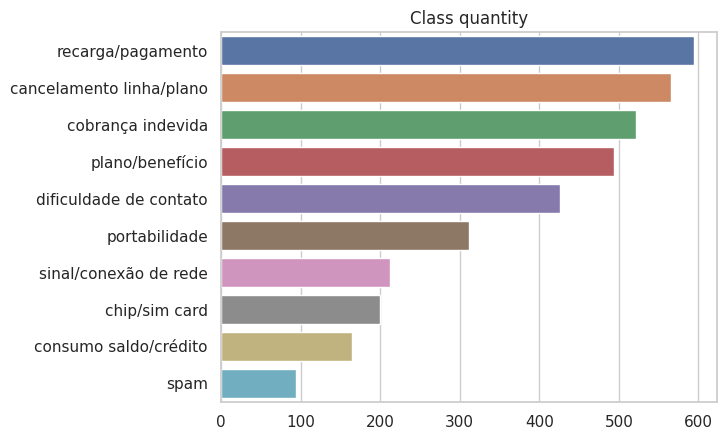

In [ ]:
# Get class quantity
df_class = df[tags]
class_qty = df_class.sum()
sns.set_style("whitegrid")

chart_class = class_qty.sort_values(ascending=False)
sns.barplot(x=chart_class.values, y=chart_class.index, orient='h')
plt.title('Class quantity');

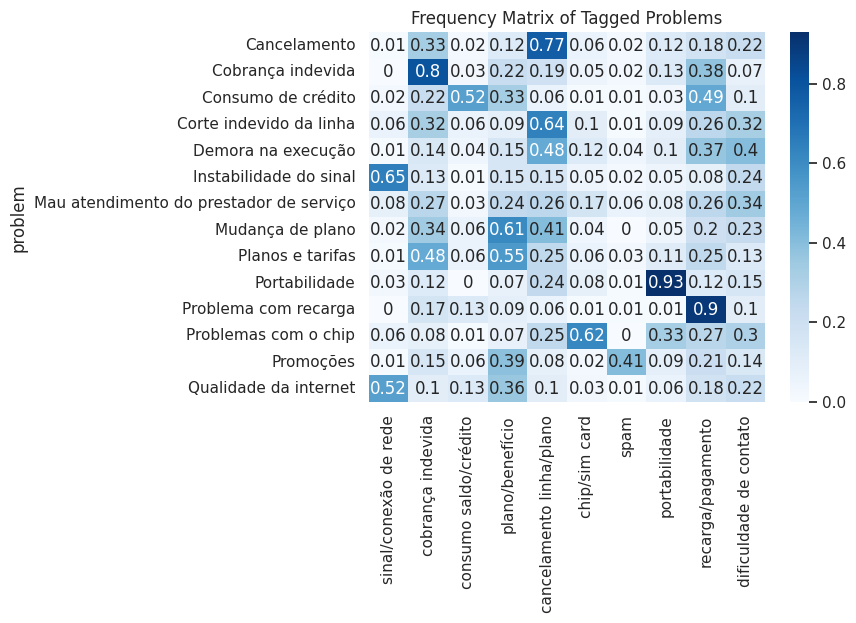

In [ ]:
# Get frequency labels per category
freq_matrix = round((df.groupby('problem')[tags].sum().T / df['problem'].value_counts().sort_index()), 2).T
sns.heatmap(freq_matrix, annot=True, cmap='Blues')
plt.title('Frequency Matrix of Tagged Problems');

---